In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
import matplotlib.pyplot as plt

2024-03-06 07:00:56.249889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 07:00:56.250043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 07:00:56.432113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def load_data(image_folder, mask_folder):
    image_list = os.listdir(image_folder)
    mask_list = os.listdir(mask_folder)

    images = []
    masks = []

    for image_file in image_list:
        # Generate corresponding mask file name
        mask_file = image_file.replace('.png', '_mask.png')
        mask_path = os.path.join(mask_folder, mask_file)

        # Check if the mask file exists
        if mask_file in mask_list:
            img_path = os.path.join(image_folder, image_file)

            # Load and preprocess images
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1]
            images.append(img_array)

            # Load and preprocess masks
            mask = load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
            mask_array = img_to_array(mask) / 255.0
            masks.append(mask_array)

    return np.array(images), np.array(masks)


# Define your U-Net model here

# Specify your dataset folders
image_folder = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/"
mask_folder ="/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks/"
# Load data
images, masks = load_data(image_folder, mask_folder)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

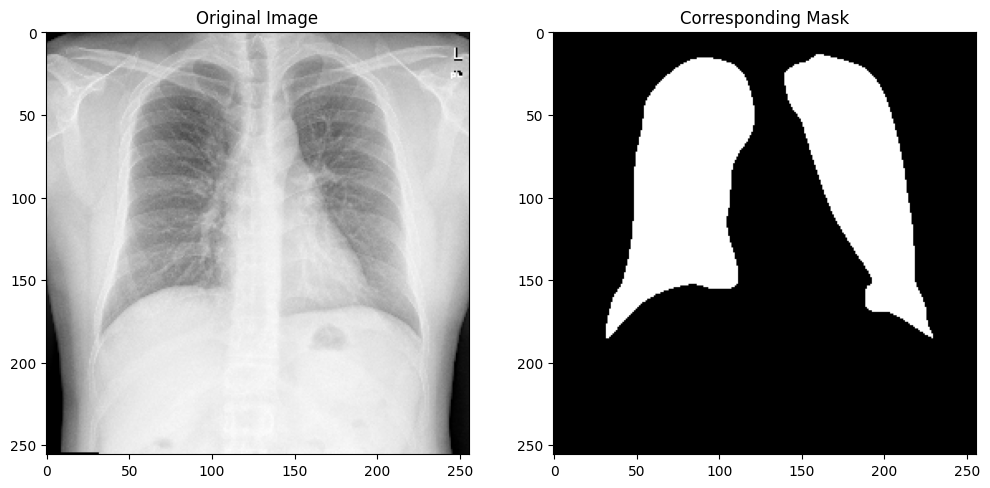

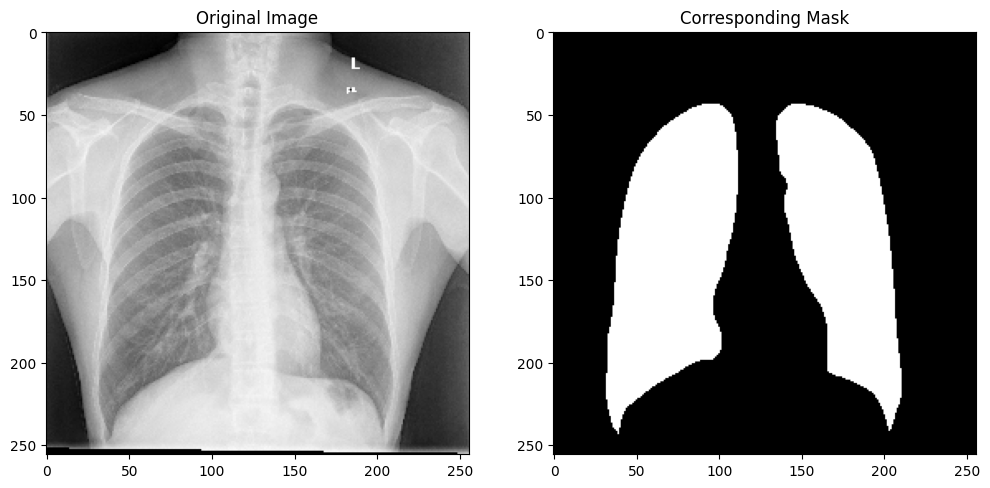

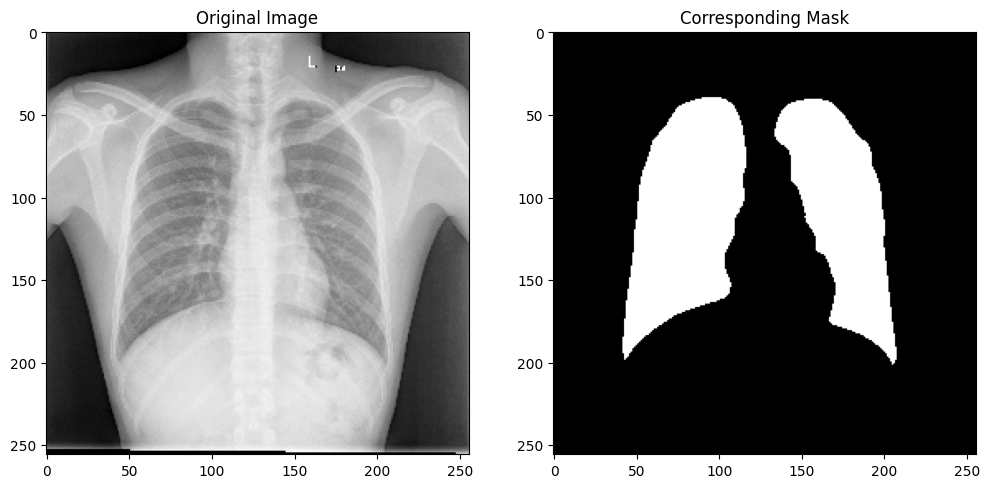

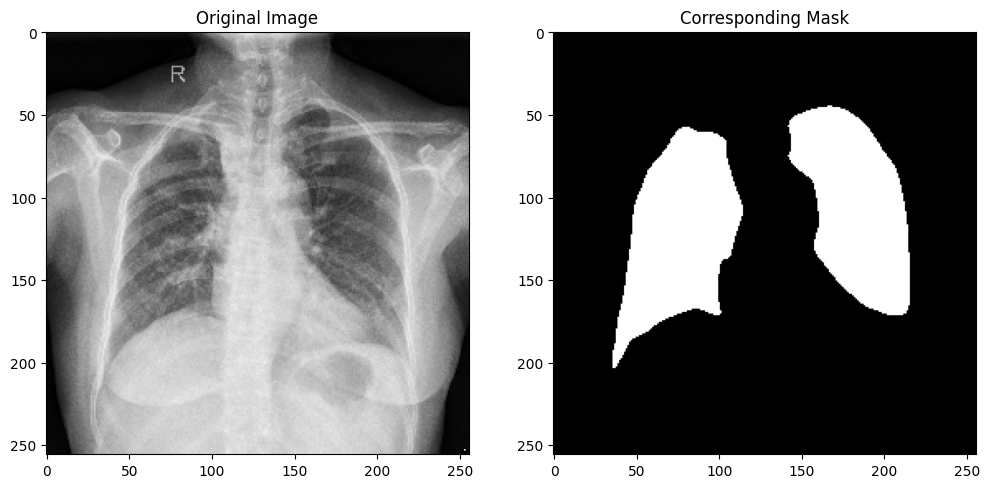

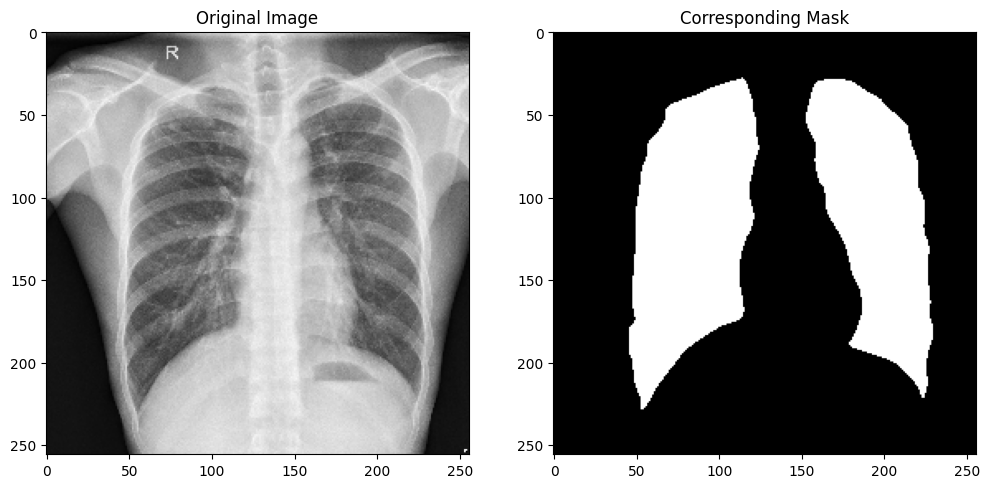

In [ ]:
import matplotlib.pyplot as plt
# Visualize a few images and masks
num_samples_to_display = 5

for i in range(num_samples_to_display):
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title('Original Image')

    # Display the corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(masks[i][:, :, 0], cmap='gray')  # Assuming masks are grayscale
    plt.title('Corresponding Mask')

    plt.show()

In [ ]:
def Unet_model():
    inputs=Input((256,256,3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model=Unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,y_train,epochs=20,validation_data=(X_val,y_val))

Epoch 1/20


2024-03-06 07:04:34.240384: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-06 07:04:34.587017: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.346750934s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-06 07:04:37.116978: E external/

15/15 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.7301 - loss: 0.6227 - val_accuracy: 0.7447 - val_loss: 0.5582
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 531ms/step - accuracy: 0.7473 - loss: 0.5471 - val_accuracy: 0.7447 - val_loss: 0.4792
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - accuracy: 0.7477 - loss: 0.4520 - val_accuracy: 0.8270 - val_loss: 0.4046
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 521ms/step - accuracy: 0.7711 - loss: 0.4686 - val_accuracy: 0.7553 - val_loss: 0.4747
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - accuracy: 0.7976 - loss: 0.3789 - val_accuracy: 0.8883 - val_loss: 0.2819
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.8560 - loss: 0.3037 - val_accuracy: 0.8834 - val_loss: 0.2692
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.8949 - loss: 0.2513 - val_accuracy: 0.9204 - val_loss: 0.2073
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 524ms/step - accuracy: 0.9198 - loss: 0.1922 - val_accuracy: 0.9375 - val_l

In [ ]:
predictions=model.predict(images)

18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step 


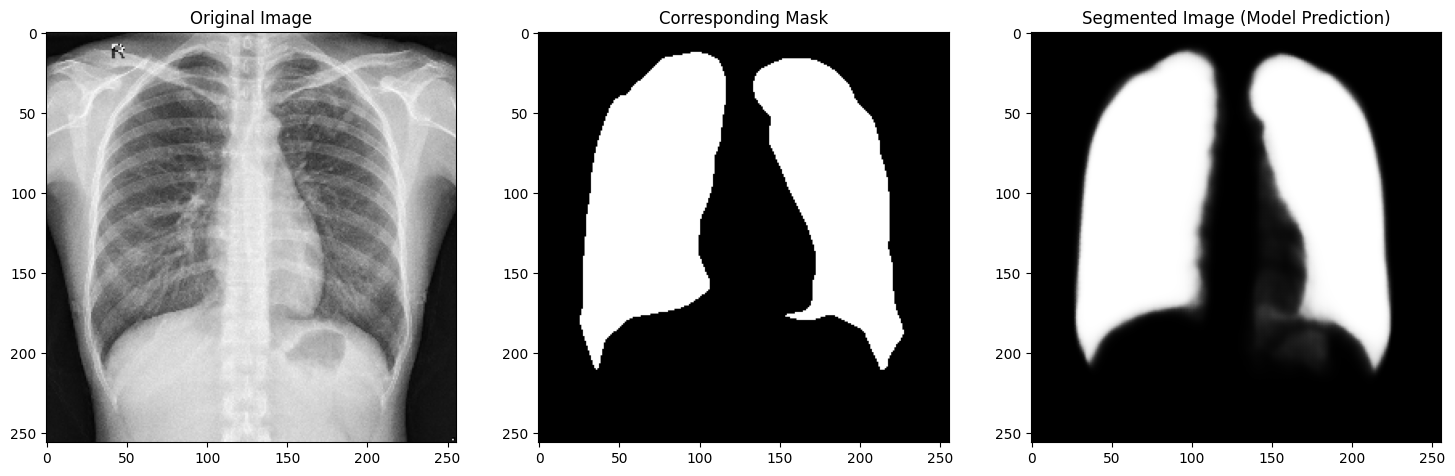

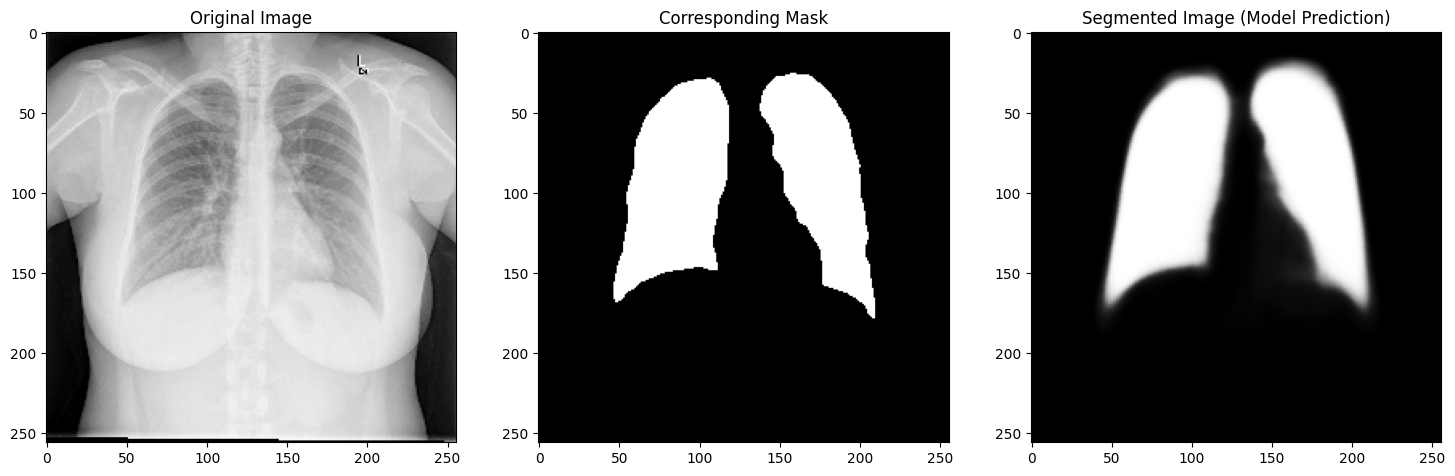

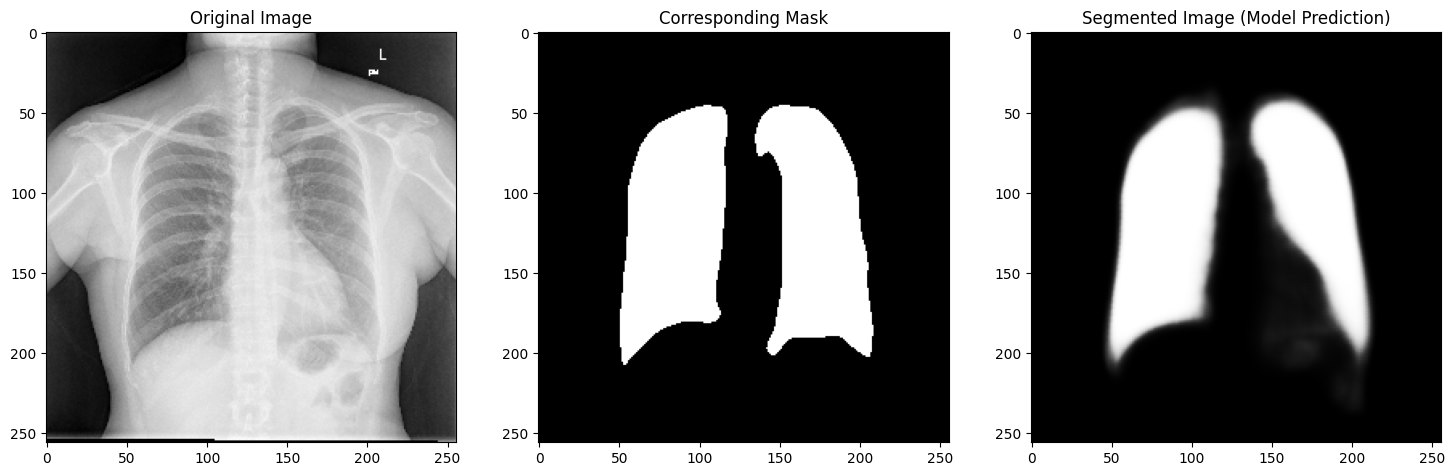

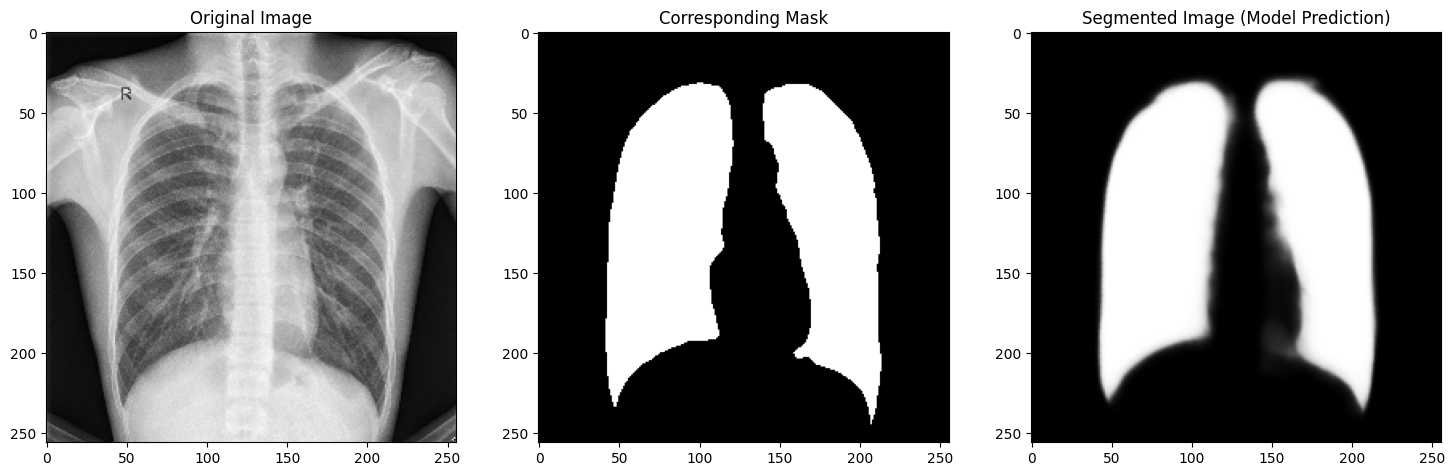

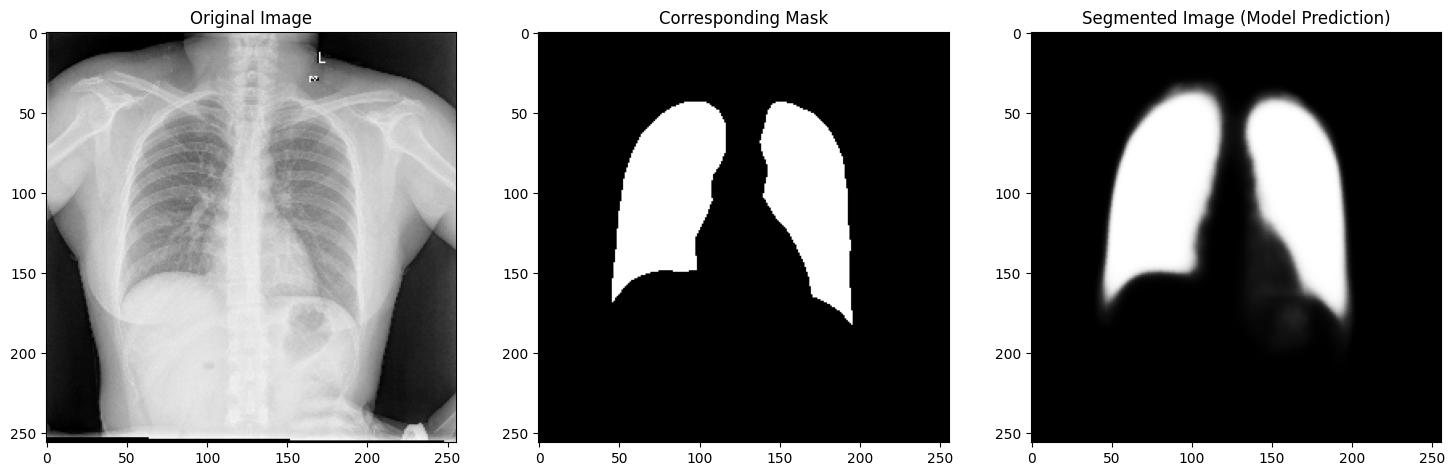

In [ ]:
for i in range(40,45):
    plt.figure(figsize=(18, 6))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(images[i])
    plt.title('Original Image')

    # Display the corresponding mask
    plt.subplot(1, 3, 2)
    plt.imshow(masks[i][:, :, 0], cmap='gray')  # Assuming masks are grayscale
    plt.title('Corresponding Mask')

    # Display the segmented image (model prediction)
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i][:, :, 0], cmap='gray')  # Assuming predictions are grayscale
    plt.title('Segmented Image (Model Prediction)')

    plt.show()

In [ ]:
model.save("Lung_Segmentation_Unet.h5")

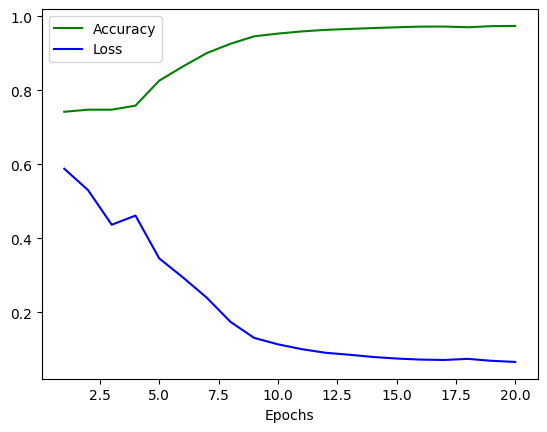

In [ ]:
plt.plot(range(1,21),history.history['accuracy'],color='g',label='Accuracy')
plt.plot(range(1,21),history.history['loss'],color='blue',label='Loss')
plt.xlabel('Epochs')
plt.legend()

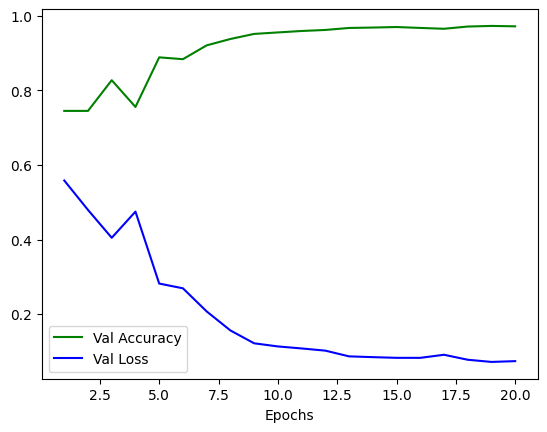

In [ ]:
plt.plot(range(1,21),history.history['val_accuracy'],color='g',label='Val Accuracy')
plt.plot(range(1,21),history.history['val_loss'],color='blue',label='Val Loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Specify the folder containing the new set of images
new_images_folder = "/kaggle/input/multiclass-lungs-x-rays/Multiclass Lung disease/Test/Bacterial Pneumonia"

# Specify the folder where you want to save the segmented images
output_folder ="/kaggle/working/Segmented/Bacterial Pneumonia"
os.makedirs(output_folder, exist_ok=True)

# Assuming your new image filenames are like 'new_image1.png', 'new_image2.png', etc.
new_image_list = os.listdir(new_images_folder)
seg_image=[]
seg_mask=[]
# Loop through the new images, make predictions, and save segmented images
for new_image_name in new_image_list:
    new_image_path = os.path.join(new_images_folder, new_image_name)

    # Load and preprocess the new image
    new_image = load_img(new_image_path, target_size=(256, 256))
    new_image_array = img_to_array(new_image) / 255.0  # Normalize pixel values to the range [0, 1]
    seg_image.append(new_image_array)
    new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

    # Make predictions using the trained model
    segmentation_mask = model.predict(new_image_array)

    # Save the segmented image
    segmented_image_path = os.path.join(output_folder, f"segmented_{new_image_name}")
    plt.imsave(segmented_image_path, segmentation_mask[0, :, :, 0], cmap='gray')  # Assuming predictions are grayscale
    seg_mask.append(segmentation_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

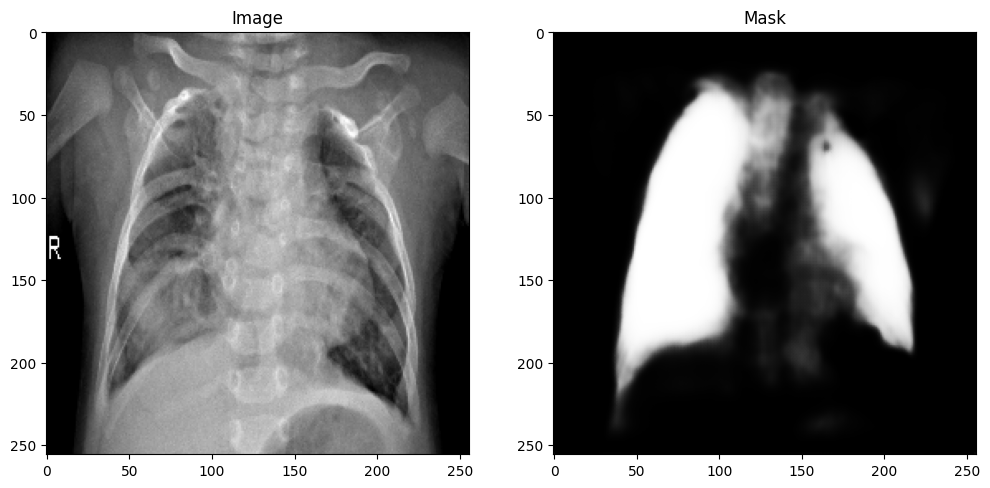

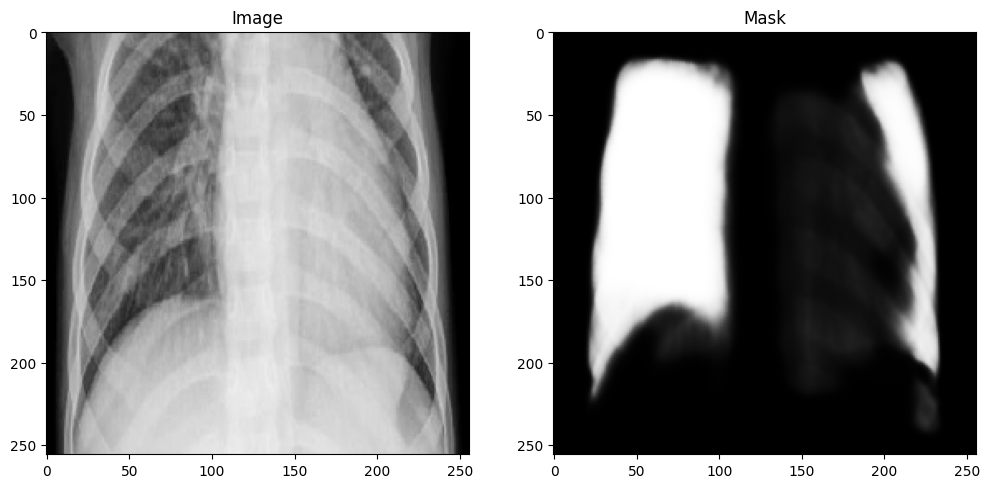

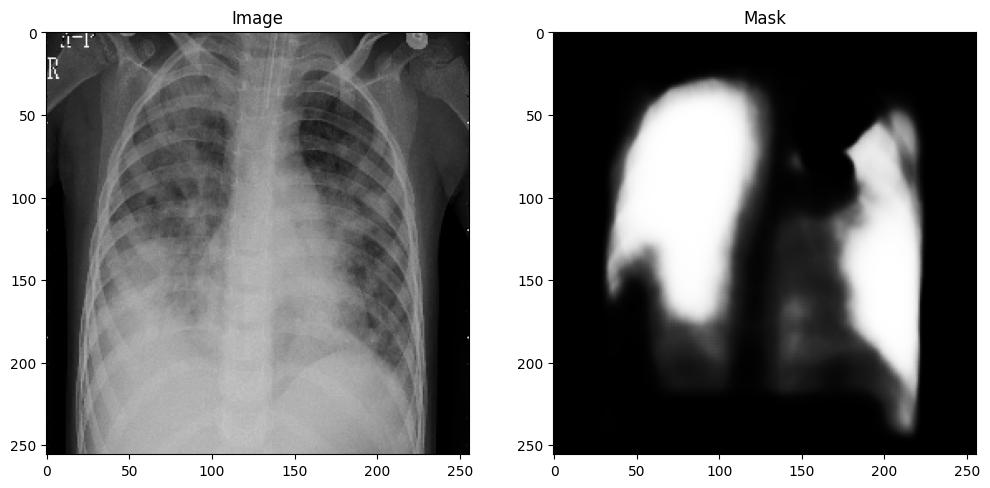

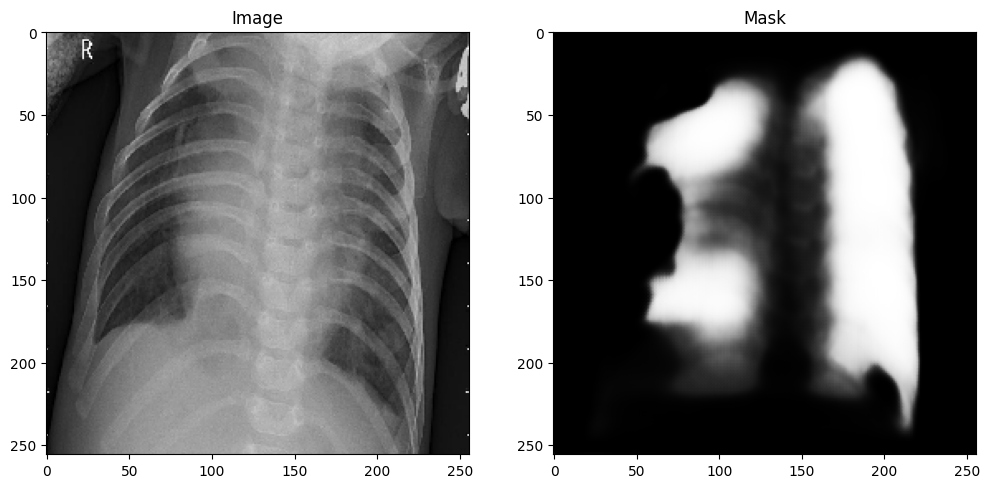

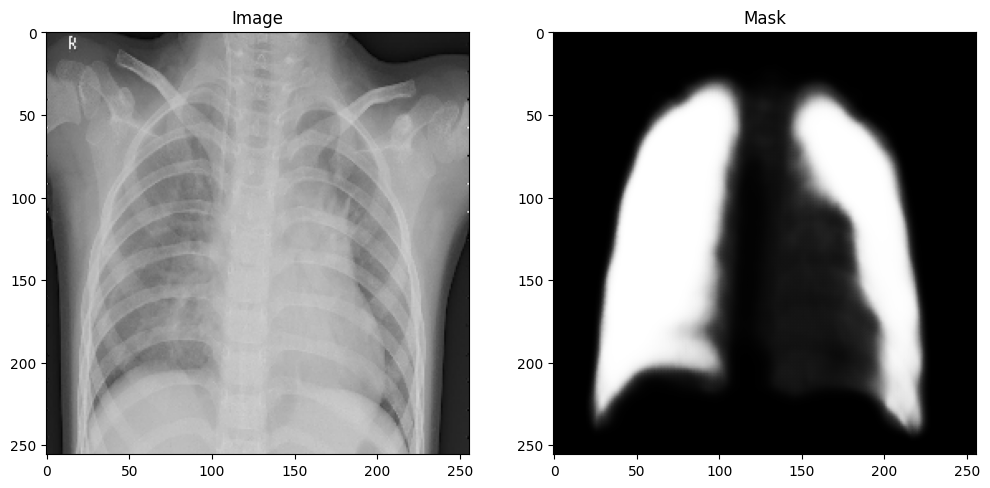

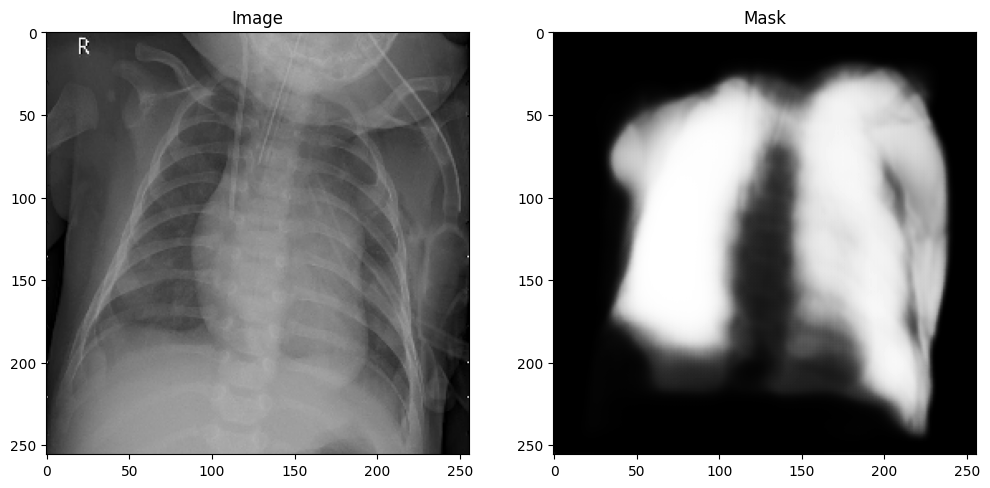

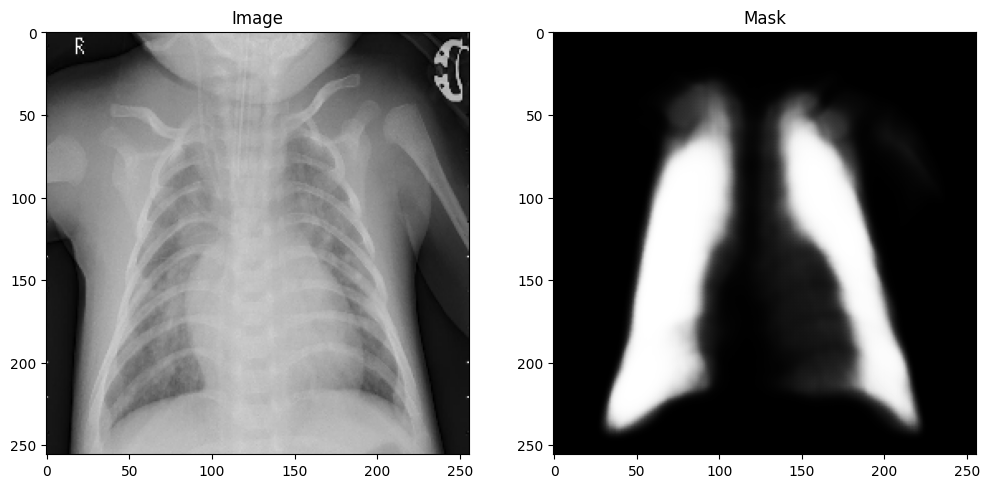

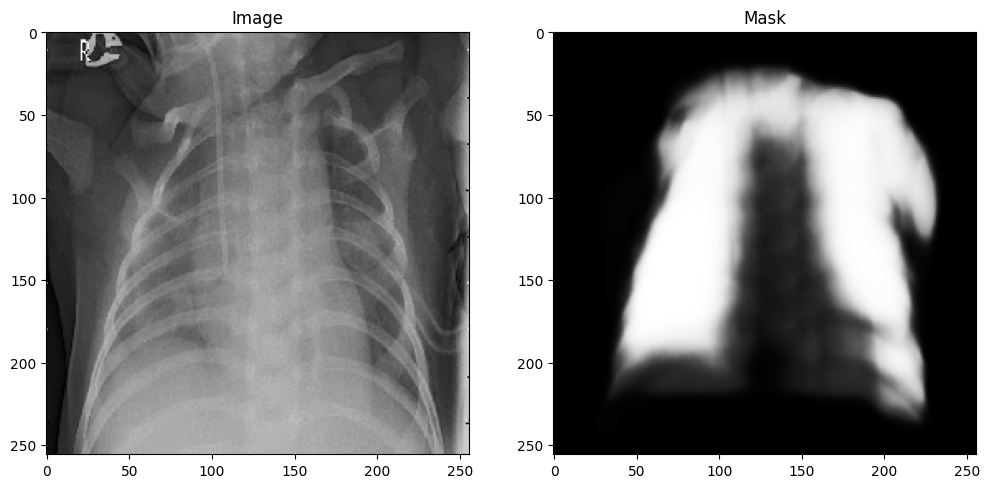

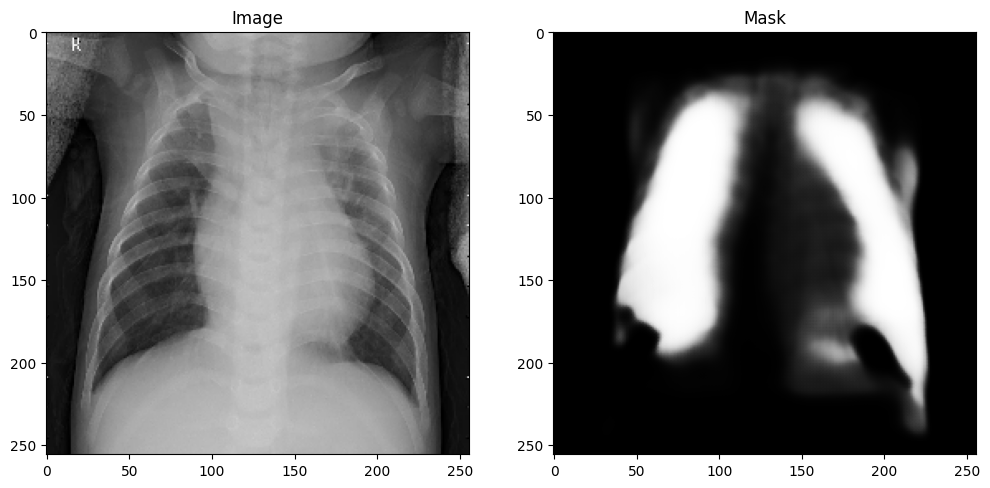

In [ ]:
for i in range(1,10):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(seg_image[i])  # Assuming masks are grayscale
    plt.title('Image')

    # Display the corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(seg_mask[i][0,:,:,0], cmap='gray')  # Assuming masks are grayscale
    plt.title('Mask')

    plt.show()

In [ ]:
model.save("LungSegmentation_UnetModel.h5")